## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
#Use pd.read_csv to read ab_data.csv file and showing the first 5 rows 
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
#Use .shape to get number of rows
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
#Use .nunique()) to get the count of unique values in user_id 
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
#Use .query to get the proportion 
(df.query('converted == 1').count()[0]/df.shape[0]).round(4)

0.1197

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
#Sum up the two cases (new page with control group) & (old page with treatment group)

old_treatment = df.query('landing_page == "old_page" & group == "treatment"')
new_control = df.query('landing_page == "new_page" & group == "control"')

old_treatment.count()[0] + new_control.count()[0]

3893

f. Do any of the rows have missing values?

In [7]:
#Use .info() to know about data types and missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


#### <font color = purple>No, we don't have any null values in any row. but we need to change the data type of the timestamp to be datatime and calculate the test period.

In [8]:
#Converting timestamp to datetime and calculating the treatment period.
df['timestamp'] = df['timestamp'].astype('str').str[:-6]
df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%Y-%m-%d %H:%M:%S')
test_period = df['timestamp'].max() - df['timestamp'].min()
test_period

Timedelta('21 days 23:59:49')

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
#Use .drop for dropping the new page and control group index.
df2 = df.drop(new_control.index, axis = 0)
#Use .drop for dropping the old page and treatment group index.
df2 = df2.drop(old_treatment.index, axis = 0)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
#Use .nunique() to get the count of unique values in user_id 
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
#Use .duplicated to get the duplicated user id
df2.user_id[df2.duplicated(['user_id'])]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
#Show the whole row of 773192 user
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58,treatment,new_page,0
2893,773192,2017-01-14 02:55:59,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
#Use .drop to remove the duplicated row
df2 = df2.drop_duplicates(['user_id'])

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
#Get the probability of coverted individual
converted = (df2.query('converted == 1').count()[0]/df2.shape[0]).round(4)
print(100*converted, "%")

11.959999999999999 %


b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
#Get the probability of converted users in control group
control = (df2.query('group == "control" & converted == 1').count()[0]/df2.query('group == "control"').count()[0]).round(4)
print(100*control, "%")

12.04 %


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
#Get the probability of converted users in treatment group
treatment = (df2.query('group == "treatment" & converted == 1').count()[0]/df2.query('group == "treatment"').count()[0]).round(4)
print(100*treatment, "%")

11.88 %


d. What is the probability that an individual received the new page?

In [18]:
#Get the probability of new page users
new_page = df2.query('landing_page == "new_page"').count()[0]/df2.shape[0]
print(100*new_page.round(4), "%")

50.01 %


e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

### <font color = purple>  Conclusions: 
    
- The control group who received the old page have a bigger probability to be converted.
- The two groups have received almost the same number of users.

So, we don't have suffiecent evidence that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$ H_0:  p_{new} - p_{old} \leq 0 $$
$$ H_1:  p_{new} - p_{old} >  0 $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
#Calculate p_new under the null
p_new = (df2.query('converted == 1').count()[0]/df2.shape[0]).round(4)
print(100*p_new, "%")

11.959999999999999 %


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
#Calculate p_old under the null
p_old = (df2.query('converted == 1').count()[0]/df2.shape[0]).round(4)
print(100*p_old, "%")

11.959999999999999 %


c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
#Use .count() to get the number of individuals in the treatment group
n_new = df2.query('landing_page == "new_page"').count()[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
#Use .count() to get the number of individuals in the control group
n_old = df2.query('landing_page == "old_page"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
#Use np.random.choice to simulate the unique values of converted column (n_new) times
new_converted = np.random.choice(df2.converted.unique(), n_new, p = [p_new, (1-p_new)])
new_converted

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
#Use np.random.choice to simulate the unique values of converted column (n_old) times
old_converted = np.random.choice(df2.converted.unique(), n_old, p = [p_old, (1-p_old)])
old_converted

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
#Get the difference between means of e & f
obs_diff = new_converted.mean() - old_converted.mean()
obs_diff

0.0014133170163096453

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
#Simulating p_diffs 10000 times
p_diffs = []
size = 10000
for i in range(10000):
    new_converted = np.random.choice(df2.converted.unique(), n_new, p = [p_new, (1-p_new)])
    old_converted = np.random.choice(df2.converted.unique(), n_old, p = [p_old, (1-p_old)])
    p_diffs.append(new_converted.mean() - old_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

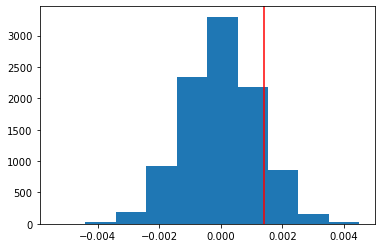

In [27]:
#Convert p_diffs to numpy array then plot a histogram 
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)
#add a red line representing the obs_diff we have.
plt.axvline(obs_diff, color ='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
#Calculate the current diff
current_diff =  treatment - control
#This is the p valuse, let's calculate it
p_value = (p_diffs > current_diff).mean()
p_value

0.9083

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The large p_value tells us that we don't have sufficient evidence (or fail) to reject the null and that suggests that there is not a significant difference between the conversion rate of the two pages and we should keep using the old one.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1').count()[0]
convert_new = df2.query('landing_page == "new_page" & converted == 1').count()[0]
n_old = df2.query('landing_page == "old_page"').count()[0]
n_new = df2.query('landing_page == "new_page"').count()[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [30]:
from statsmodels.stats.proportion import proportions_ztest

stat, pval = proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
stat, pval

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**This p_value is also large and close to the one we got from j., hence we fail to reject the null in favor of the alternative, and we can advice the company to continue in using the old page for now and to run the A/B test for longer period..**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
#Add an intercept 
df2['intercept'] = 1
#Create dummies for group
df2[['control', 'ab_page']] = pd.get_dummies(df['group'])
#Drop control column and have only ab_page
df2 = df2.drop('control', axis=1)

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [32]:
#Fit the model
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
#Get the summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 21 May 2021   Pseudo R-squ.:               8.077e-06
Time:                        23:48:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Our P value associated to ab_page here is 0.190, and it differs from the value we got from hypothesis test because here it is a two tailed test has the hypothses as following:** <br>
$$ H_0: p_{new} - p_{old} = 0$$
$$ H_1: p_{new} - p_{old} \neq 0$$

**But in hypothesis test we were performing one tailed test with a type on error 5% (0.05).**<br>
$$ H_0: p_{new} - p_{old} \leq 0$$
$$ H_1: p_{new} - p_{old} > 0$$
**Although p value here is different than what we got before, it is still larger than 0.05 (our alpha) and that means we fail to reject the null hypothsis in favor of the alternative**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

#### That's a good idea because:

- Neglecting some terms could give us incorrect results and insights.

#### For our case, in my opinion we have to take some points in consideration as :

- Whether this individual is visiting the company page for the first time or he is an old user. old users may affect our model negatively because they used to a certain page design and may leave the page just because of confusing but when they get familiar with the new page they will interact with it as usual.
- How much time user spend in the page is an important point too, user may open the page by mistake or didn't dive in deep to decide to turn to converted user or not.

#### Adding additional terms is not always a good idea because some terms:

- It may be misleading.
- Don't have linear relationship with our x variable.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [34]:
#Read countries.csv file.
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [35]:
#Join the two dataframes using inner joint on user_id 
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [36]:
#Know our country values 
countries_df.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [37]:
#Create dummy variables for (US, UK, CA) 
df_new[['US', 'UK', 'CA']] = pd.get_dummies(df_new['country'])

In [38]:
# Fit Your Linear Model And Obtain the Results
df_new['intercept'] = 1
lm = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 21 May 2021   Pseudo R-squ.:               2.323e-05
Time:                        23:48:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

#### All the p values associated to our factors (ab_page, countries) are bigger than our alpha (0.05) which also means that we should stay with our null hypothsis as we don't have sufficient evidence to reject the null in favor of the alternative.

In [39]:
#Get the exponential of our factors coeffecients
np.exp(-0.0149), np.exp(-0.0408), np.exp(0.0099)

(0.9852104557227469, 0.9600211149716509, 1.0099491671175422)

In [40]:
#Get the reciprocal for values < 1 (that will be in case of decreasing)
1/np.exp(-0.0149), 1/np.exp(-0.0408)

(1.0150115583846535, 1.0416437559600236)

#### Based on this statistical report, we can see that there is very weak impact of countries on the conversion rate: 
- The UK user may likely has a better chance to be converted (1.01 times than CA).
- The US user may likely has a lower chance to be converted (1.04 times than CA).

#### The page also has a little impact, users who received the new page are not likely to turn to converted users (1.015 times the old page.)

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
df_new['uk_new'] = df_new['UK'] * df_new['ab_page']
df_new['us_new'] = df_new['US'] * df_new['ab_page']

In [42]:
# Fit Your Model And Obtain the Results
df_new['intercept'] = 1
lm = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK', 'us_new', 'uk_new']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 21 May 2021   Pseudo R-squ.:               3.482e-05
Time:                        23:48:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
US            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
us_new        -0.0469      0.054     -0.872      0.383      -0.152       0.059
uk_new         0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

We still have large p values for all parameters and that will lead us to stay with the null (old page is better). 

In [43]:
#Get the exponential of our new parameters coeffecients
np.exp(0.0314), np.exp(-0.0469)

(1.0318981806179213, 0.9541828111007262)

In [44]:
#Get the reciprocal for values < 1 (that will be in case of decreasing)
1/np.exp(-0.0469)

1.048017202119183

In [45]:
When looking at the coeffecients we have, we can say that we have the same results as before:
UK Users may likely turn to converted than CA, and US users have a lower chance to turn converted than CA.

SyntaxError: invalid syntax (<ipython-input-45-d1e6ede33a80>, line 1)

### Conclusions
To start analyzing the attached results from A/B test for a company, we took a look at our data and prepare it to analysis by dropping the duplicated rows, repeated users id, and also mismatching results (control group with new page & treatment group with old page).
Now we have the data in good format, we will analyze it in many different ways:<br>

**1- Statistical Probabilities:** 

Conversion rate: 12%
Old page conversion rate: 12.04% with 49.99% showing rate.
New page conversion rate: 11.88% with 50.01% showing rate.
That may suggest that the old page is better but the difference range is really small and don't reflect any directions.

**2- Hypothesis Testing:**

Here we will perform hypothesis test in a Type I error of (5%) which means \alpha = 0.05, we assumed that the old page is better till we have an evidence that the new one has higher conversion rate and that could be represented as following:
𝐻0:𝑝𝑛𝑒𝑤−𝑝𝑜𝑙𝑑≤0
𝐻1:𝑝𝑛𝑒𝑤−𝑝𝑜𝑙𝑑>0

We simulated the difference between conversion rate of new page and old page of 10,000 sample and got a very small difference could tend to zero, then we calculated the P value which will help us to take a decision and it was significantly large which leads us to build an initial opinion to stay with the null (old page). We used another technique to calculate the P value and reach same result.

**3- Regression:**

Since we need to predict whether an individual will be converted or not, we will use the logistic regression, we prepared our dataframe and fitted the model and got the summary which agreed also with our hypothesis testing results and we can note a slightly effect of the page to the conversion rate (-0.015) the coff associated with ab_page. 

New data has been invited to our model (country) we have three countries (US, UK, CA), we repeated the last process of creating dummies (using only 2 in case of 3) and got the summary of the fitted model which concluded that all the factors have very little impact on the results, we may say that if the user from US, that would be more likely to turn converted than UK & CA.

Finally we can suggest the following:
- Continue in the treatment for a longer time.
- Stay with the old page.
- Get more detailed data about users and treatment like (age, time spent).
- Show the new page more to new users, old users data could be biased.

In [46]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0